https://stackoverflow.com/questions/56791124/rectangular-lattice-fit-to-noisey-coordinates

In [1]:
import numpy as np
import matplotlib.pylab as plt

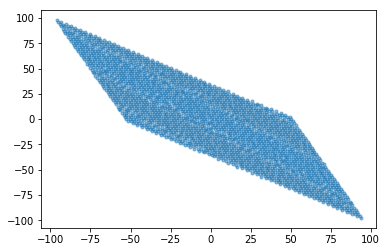

In [755]:
# Generate some noisy random grid

ab = (np.random.rand(2, 2) -.5)*6

n = np.random.randint(40)

ij_list = np.mgrid[-n:n, -n:n].reshape((2, -1), order='F').T
# F: the first index changing fastest

# Remove some points, and mix
#selection = np.random.choice(len(ij_list), int(.9*len(ij_list)),
#                            replace=False)
#ij_list = ij_list[selection]


xy = np.matmul(ij_list, ab)
xy += 0.05 *np.sum(np.sum(ab, axis=1)**2)*np.random.randn(*np.shape(xy))

#xy = xy[np.sum(xy**2, axis=1) < .5*(3*n)**2]

plt.plot(*xy.T, '.', alpha=.5);

In [756]:
approx_distance = np.sqrt(np.prod(xy.ptp(axis=0))/len(xy))

In [760]:
k_search = np.linspace(.1, 10, 150)/approx_distance

In [761]:
kx, ky = np.meshgrid(k_search, k_search)

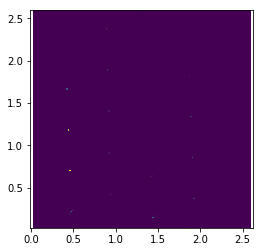

In [762]:
k_dot_r = kx[:, :, np.newaxis]*xy[:, 0] +\
          ky[:, :, np.newaxis]*xy[:, 1]

TF = np.sum(np.exp(2*np.pi*1j*k_dot_r), axis=2)
PSD = np.abs(TF)**2

plt.figure(figsize=(4, 4))
plt.pcolormesh(k_search, k_search, PSD);
plt.axis('equal');

amax = np.argmax(PSD)
i, j = np.unravel_index(amax, np.shape(PSD))
kx_max, ky_max = k_search[i], k_search[j]

In [763]:
kx_max, ky_max

(0.6979036349993508, 0.4566830768674056)

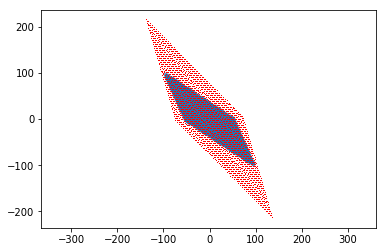

In [767]:
plt.plot(*xy.T, '.', alpha=.5);

plt.plot(xy[:, 0]/kx_max, xy[:, 1]/ky_max, ',r')
plt.axis('equal');

## avec matrice de tr. inverse

In [500]:
# Get a cost function

In [458]:
ab_inv = np.random.rand(2, 2)
offset = np.random.rand(2)

In [459]:
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

In [548]:
def cost(p):
    ab_inv = np.array(p[:4]).reshape(2, 2).T
    offset = np.array(p[4:])
    
    uv = np.matmul(ab_inv, xy.T).T - offset
    return np.sum((np.around(uv) - uv)**2)

In [549]:
p0 = [1, -1, -.4, 1.4, 0, 0]
bounds = [(-10, 10), ]*4 + [(0, 1), (0, 1)]
sol = dual_annealing(cost, bounds)
sol

     fun: 62.24176183198846
 message: ['Maximum number of iteration reached']
    nfev: 13821
    nhev: 0
     nit: 1000
    njev: 0
       x: array([-9.07442591e-01, -3.22350188e+00,  4.75411715e+00, -2.26728411e+00,
        6.19292555e-01,  1.96973214e-03])

In [550]:
sol.x

array([-9.07442591e-01, -3.22350188e+00,  4.75411715e+00, -2.26728411e+00,
        6.19292555e-01,  1.96973214e-03])

In [551]:
np.linalg.inv(ab)

array([[-0.32232002, -0.66781819],
       [-0.22676572,  1.00111372]])

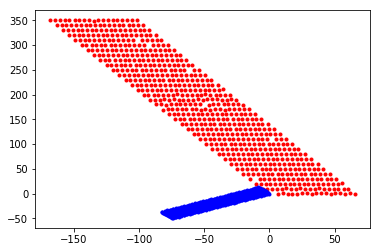

In [552]:
p = sol.x
ab_inv = np.array(p[:4]).reshape(2, 2).T
offset = np.array(p[4:])
uv = np.matmul(ab_inv, xy.T).T - offset

plt.plot(*uv.T, '.r');
plt.plot(*xy.T, '.b');

## projection

In [649]:
def proj(s):
    u = np.array([s, np.sqrt(1 - s**2)])
    projections = np.dot(xy, u)
    return projections

In [650]:
def get_min_std(s):
    p = proj(s)
    p = (p-np.min(s))/p.ptp()
    
    #all_std = [np.std(p*n - np.around(p*n)) for n in range(1, 200)]
    
    all_std = [np.sum(np.cos(p*n*2*np.pi))**2+np.sum(np.sin(p*n*2*np.pi))**2
          for n in range(5, 200)]
    return max(all_std)

In [651]:
s = .75

In [652]:
p = proj(s)
p = (p-np.min(s))/p.ptp()

n = 20
np.std(p*n - np.around(p*n))

0.28848132873484905

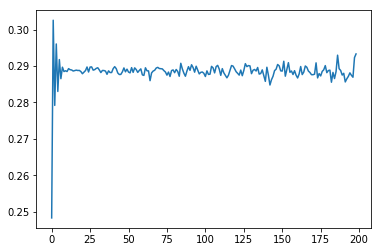

In [653]:
plt.plot([np.std(p*n - np.around(p*n)) for n in range(1, 200)])

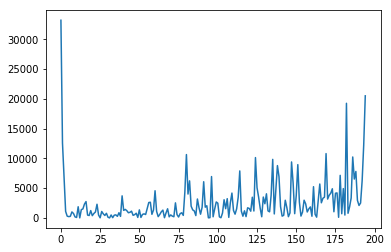

In [654]:
plt.plot([np.sum(np.cos(p*n*2*np.pi))**2+np.sum(np.sin(p*n*2*np.pi))**2
          for n in range(5, 200)])

In [541]:
def get_max_d(s):
    u = np.array([s, np.sqrt(1 - s**2)])
    projections = np.sort(np.dot(xy, u))
    max_d = np.max(np.diff(projections))
    return max_d

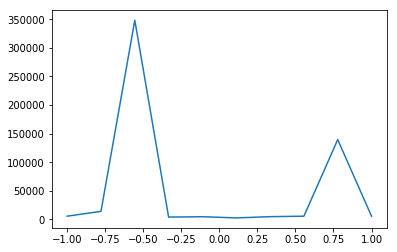

In [577]:
s_span = np.linspace(-1, 1, 10)
d = [get_min_std(s) for s in s_span]

plt.plot(s_span, d, '-')

In [493]:
s_argmax = s_span[np.argmax(d)]

In [535]:
s = s_argmax
def plot_distrib_d(s):
    u = np.array([s, np.sqrt(1 - s**2)])
    projections = np.sort(np.dot(xy, u))
    distances = np.sort(np.diff(projections))
    max_d = np.max(distances)

    plt.hist(distances)
    #plt.plot(len(projections), max_d, 'ok')


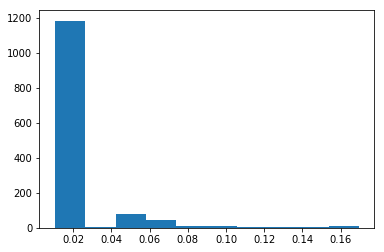

In [538]:
plot_distrib_d(.7)

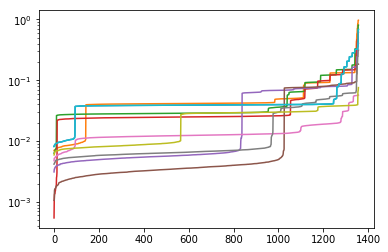

In [534]:
for s in np.linspace(-1, 1, 10):
    plot_distrib_d(s)

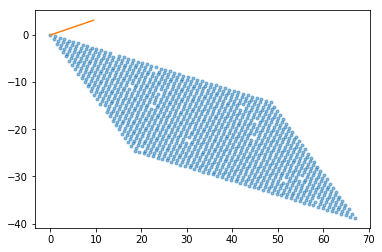

In [528]:
s = s_argmax

plt.plot(*xy.T, '.', alpha=.5);
plt.plot([0, 10*s], 10*np.array([0, np.sqrt(1-s**2)]))

# 2D sort of reciprocal space

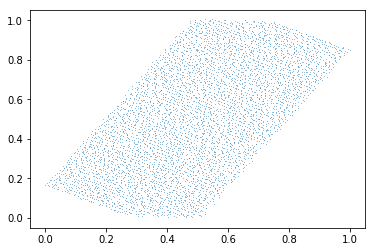

In [687]:
xy_normed = (xy - np.min(xy, axis=0))/xy.ptp(axis=0)
plt.plot(*xy_normed.T, ',', alpha=.5);

In [683]:
K = np.mgrid[5:100, 5:100]

kr = K[0, :, :, np.newaxis]*xy_normed[:, 0] +\
     K[1, :, :, np.newaxis]*xy_normed[:, 1]

TF = np.sum(np.exp(2*np.pi*1j*kr), axis=2)

In [688]:
np.dot?

Docstring:
dot(a, b, out=None)

Dot product of two arrays. Specifically,

- If both `a` and `b` are 1-D arrays, it is inner product of vectors
  (without complex conjugation).

- If both `a` and `b` are 2-D arrays, it is matrix multiplication,
  but using :func:`matmul` or ``a @ b`` is preferred.

- If either `a` or `b` is 0-D (scalar), it is equivalent to :func:`multiply`
  and using ``numpy.multiply(a, b)`` or ``a * b`` is preferred.

- If `a` is an N-D array and `b` is a 1-D array, it is a sum product over
  the last axis of `a` and `b`.

- If `a` is an N-D array and `b` is an M-D array (where ``M>=2``), it is a
  sum product over the last axis of `a` and the second-to-last axis of `b`::

    dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])

Parameters
----------
a : array_like
    First argument.
b : array_like
    Second argument.
out : ndarray, optional
    Output argument. This must have the exact kind that would be returned
    if it was not used. In particular, it must have the r

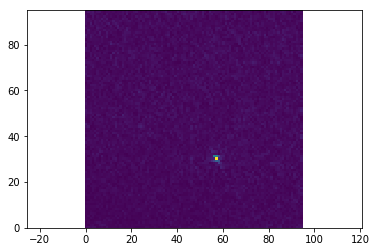

In [684]:
plt.pcolormesh(np.abs(TF));
plt.axis('equal');

In [686]:
amax = np.argmax(np.abs(TF))
np.unravel_index(amax, np.shape(TF))